<a href="https://colab.research.google.com/github/moshe-hadad/knesset-network/blob/main/collaboration_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="text-align: center;">
    <img src="https://en.idi.org.il/media/9162/knesset.jpg" alt="Knesset" />
    <h1>Knesset Network Project - Finding the rebel</h1>
</div>


## Basic functions to download  Knesset data and merge it to one data set.

### The table structure is as follows

| BillInitiatorID | BillID  | PersonID | FactionID | Name                                              |
|------------------|---------|----------|-----------|---------------------------------------------------|
| 0               | 171727  | 2086198  | 30701     | הליכוד בהנהגת בנימין נתניהו לראשות הממשלה          |
| 1               | 171950  | 2086395  | 30067     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 2               | 174658  | 2086395  | 30719     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 3               | 174659  | 2086395  | 30066     | הרשימה המשותפת (חד"ש, תע"ל, בל"ד)                |
| 4               | 183498  | 2156051  | 30672     | יהדות התורה והשבת - אגודת ישראל דגל התורה          |


In [3]:
import pandas as pd
from tqdm import tqdm

DATA_BASE_URL ='https://raw.githubusercontent.com/moshe-hadad/knesset-network/main/data'

FACTION_URL =f'{DATA_BASE_URL}/factions.csv'
FACTION_PEOPLE_URL = f'{DATA_BASE_URL}/faction_people.csv'
PERSONS_URL = f'{DATA_BASE_URL}//KNS_Person_data.csv'
BILLS_INITIATORS_URL = f'{DATA_BASE_URL}//KNS_BillInitiator.csv'
BILLS_URL = f'{DATA_BASE_URL}/KNS_Bill.csv'
CHUNK_SIZE =10000


KNESSET_NUM = 24

# Define a function to remoatly load the data sets with a progress bar
def remote_loader(url: str, chunk_size: int = CHUNK_SIZE):
    # Initialize tqdm progress bar (unknown total)
    progress_bar = tqdm(unit="lines")
    # Read CSV in chunks with an iterator
    data_frames = pd.read_csv(url, chunksize=chunk_size)

    # Process each chunk while updating progress bar
    final_df = pd.DataFrame()  # Empty DataFrame to store results
    for chunk in data_frames:
        final_df = pd.concat([final_df, chunk], ignore_index=True)
        progress_bar.update(len(chunk))

    # Close the progress bar
    progress_bar.close()

    # Display the loaded DataFrame (optional)
    return final_df

def knesset_data_set(knesset_number=KNESSET_NUM):
  # ----------- Merge Bill and their initiator ---------------------------------
  bills_initiators = remote_loader(BILLS_INITIATORS_URL)
  bills = remote_loader(BILLS_URL)

  # Filter bills for the specific Knesset term (number)
  filter_per_knesset_term_df = bills[bills['KnessetNum'] == knesset_number]
  filter_per_knesset_term_df.head()
  # Merge the data sets
  bills_and_members = pd.merge(bills_initiators, filter_per_knesset_term_df,
                               on='BillID', how='inner')

  # ----------- Merge Factions and their members--------------------------------
  members = remote_loader(FACTION_PEOPLE_URL)
  factions_df = remote_loader(FACTION_URL)

  # members.set_index('PersonID', inplace=True)
  members = members[members['KnessetNum'] == knesset_number]
  factions_df = factions_df[factions_df['KnessetNum'] == knesset_number]
  factions_df = factions_df.drop('KnessetNum', axis=1)

  factions_and_members = pd.merge(factions_df, members, on='FactionID',
                                  how='inner')

  # ---------- Megre all to one data set ---------------------------------------
  # Drop name from bills_and_members to prevent collition with Faction Name
  bills_and_members = bills_and_members.drop('Name', axis=1)
  bills_and_factions = pd.merge(bills_and_members, factions_and_members,
                                on='PersonID', how='left')

  bills_and_factions =  bills_and_factions[['BillInitiatorID', 'BillID',
                                            'PersonID', 'FactionID', 'Name']]
  return bills_and_factions



# A walthrough of the logic of merging the data set

---
We first want to merge the billd and bills_initiator.
The bills_initiator is a connecting table between members (persons) and bills.
Since there is a many to many relationship between members and bills.  
One member can be linked to multiple bills and vice versa.  

But before we merge we filter the bills tables for all the bills from the selected knesset.  
We then merge both tables base on BillID. The results is a table containing all the members connected to thier bills issues in the selected knesset.
We call this table bills_and_members.


Next, we merge the faction (parties) and the members (persons) table.  
Again we first filter for the selected knesset. And we merge the tables based on PersonID - the results is the table of all members and thier party.
This was done to get the party name per each member.
We call this table factions_and_members

The last part is merging the factions_and_members to the bills_and_members based on the personID (member). The results is a table containing the bills in a spesific knesset, it's member and his/her party.











## Basic funtions to build factions graph from the data set




In [4]:
# prompt: From the data set bills_and_factions , I want to create a graph where each node represent a faction and there is an edge between nodes if there are members who issued a bill together. The weight of the edge is the count of such colaborations

import networkx as nx

def build_faction_graph(bills_and_factions):
    # Create an empty graph
    graph = nx.Graph()

    # Iterate through the DataFrame to create nodes and edges
    for bill_id, group in tqdm(bills_and_factions.groupby('BillID')):
        factions = group['FactionID'].unique()
        for i in range(len(factions)):
            for j in range(i + 1, len(factions)):
                faction1 = factions[i]
                faction2 = factions[j]
                if graph.has_edge(faction1, faction2):
                    graph[faction1][faction2]['weight'] += 1
                else:
                    graph.add_edge(faction1, faction2, weight=1)

    return graph


In [5]:

bills_and_factions = knesset_data_set()
faction_graph = build_faction_graph(bills_and_factions)

163991lines [00:01, 134325.08lines/s]
56328lines [00:01, 47431.35lines/s]
4035lines [00:00, 8672.69lines/s]
543lines [00:00, 1082.29lines/s]
100%|██████████| 4079/4079 [00:00<00:00, 11814.40it/s]


In [6]:
# Get faction names for labels
faction_names = bills_and_factions.set_index('FactionID')['Name']

# Reverse the strings in the faction_names Series
faction_names = faction_names.apply(lambda x: x[::-1])

# Convert to dictionary for labels
faction_names = faction_names.to_dict()
faction_names

{962: 'הלשממה תושארל והינתנ ןימינב תגהנהב דוכילה',
 964: ')ד"לב ,ל"עת ,ש"דח( תפתושמה המישרה',
 965: 'הרותה לגד לארשי תדוגא - תבשהו הרותה תודהי',
 971: 'ס"ש',
 961: 'תיתדה תונויצה',
 974: 'דחא דיתע',
 968: 'ונתיב לארשי',
 967: 'דיתע שי',
 972: 'השדח הווקת',
 970: 'צרמ',
 969: 'ןבל לוחכ',
 966: 'טנב ילתפנ תושארב הנימי',
 963: 'הדובעה',
 973: 'תדחואמה תיברעה המישרה'}

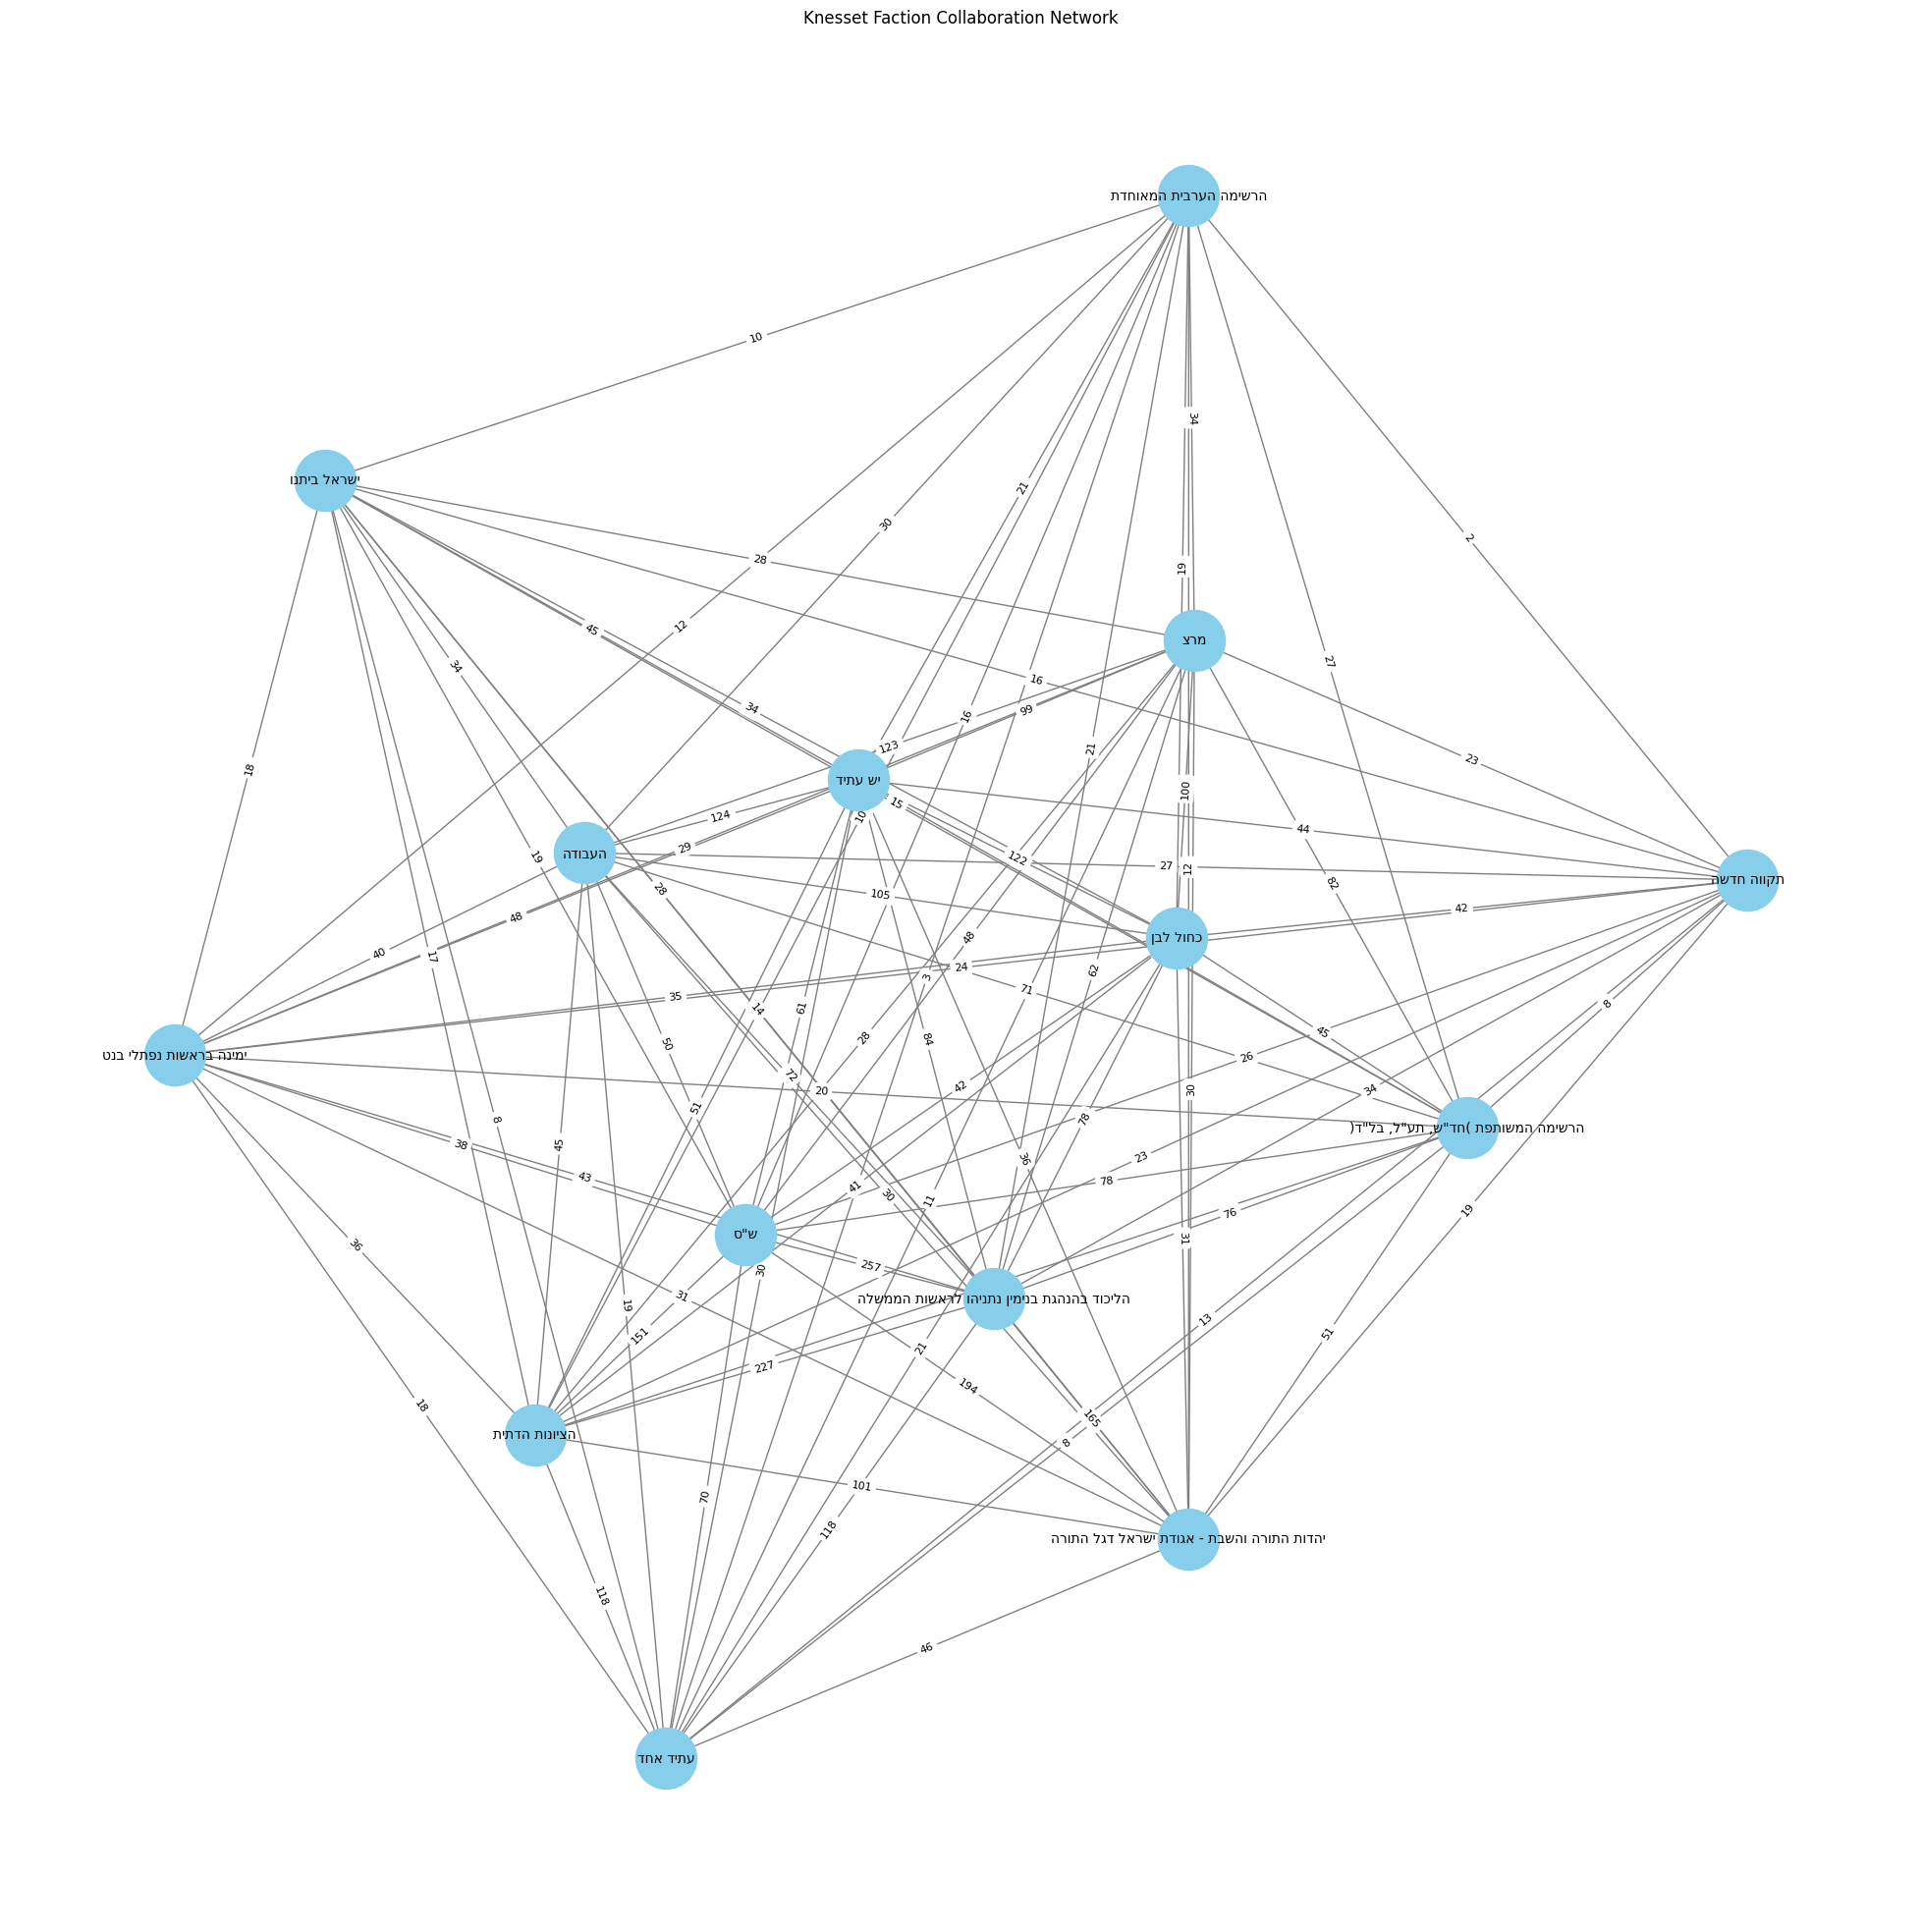

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create a larger figure
plt.figure(figsize=(25, 25))


# Draw the graph with faction names as labels
pos = nx.spring_layout(faction_graph, k=0.5, iterations=50)  # Positioning for better visualization
nx.draw_networkx(faction_graph, pos, labels=faction_names,
                 with_labels=True, node_size=2000, font_size=10,
                 node_color="skyblue", font_color="black",  edge_color="grey")


# Get and display edge weights
edge_weights = nx.get_edge_attributes(faction_graph, 'weight')
nx.draw_networkx_edge_labels(faction_graph, pos, edge_labels=edge_weights,
                             font_size=8)

plt.title("Knesset Faction Collaboration Network")
plt.axis('off')  # Hide axis
plt.show()



# Validating Data

---

Let's try to validate the data for the הרשימה הערבית המאוחדת and תקווה חדשה
From the graph, it looks like they have only 2 bills issued together for the 24th knesset

In [8]:
factions_df = remote_loader(FACTION_URL)
factions_for_24 = factions_df[factions_df['KnessetNum'] == 24]
# 'הרשימה הערבית המאוחדת' = 973
# 'תקווה חדשה' = 972




543lines [00:00, 1097.42lines/s]


In [9]:
# Extract all bills which are issued by members of factions with IDs 972 and 972
# for the 24th Knesset
bills_initiators = remote_loader(BILLS_INITIATORS_URL)
bills = remote_loader(BILLS_URL)

# Filter bills for the specific Knesset term (number)
filter_per_knesset_term_df = bills[bills['KnessetNum'] == 24]
# Merge the data sets
bills_and_members = pd.merge(bills_initiators, filter_per_knesset_term_df,
                              on='BillID', how='inner')

# ----------- Merge Factions and their members--------------------------------
members = remote_loader(FACTION_PEOPLE_URL)
members_of_973 = members[members['FactionID'].isin([973])]
members_of_972 = members[members['FactionID'].isin([972])]

163991lines [00:00, 198890.13lines/s]
56328lines [00:00, 57931.31lines/s]
4035lines [00:00, 7293.53lines/s]


In [10]:
list_of_973_members = list(members_of_973['PersonID'])
list_of_972_members  = list(members_of_972['PersonID'])


In [11]:

bills_of_members_of_973_for_knesset_24 = bills_and_members[bills_and_members['PersonID'].isin(list_of_973_members)]
bills_of_members_of_972_for_knesset_24 = bills_and_members[bills_and_members['PersonID'].isin(list_of_972_members)]

In [12]:
joint_bills_of_973_and_972 = pd.merge(bills_of_members_of_973_for_knesset_24, bills_of_members_of_972_for_knesset_24, on='BillID', how='inner')
joint_bills_of_973_and_972

BillInitiatorID_x   BillID  PersonID_x IsInitiator_x  Ordinal_x  \
0             189895  2159427       30803          True         29   
1             189895  2159427       30803          True         29   
2             189895  2159427       30803          True         29   
3             192055  2161234       30713          True         38   
4             192055  2161234       30713          True         38   

       LastUpdatedDate_x_x  KnessetNum_x  \
0  2021-07-04T14:22:58.647            24   
1  2021-07-04T14:22:58.647            24   
2  2021-07-04T14:22:58.647            24   
3    2021-10-27T13:49:51.9            24   
4    2021-10-27T13:49:51.9            24   

                                              Name_x  SubTypeID_x  \
0              הצעת חוק יום בריאות הנפש, התשפ"א-2021           54   
1              הצעת חוק יום בריאות הנפש, התשפ"א-2021           54   
2              הצעת חוק יום בריאות הנפש, התשפ"א-2021           54   
3  הצעת חוק שידורי טלוויזיה (כתוביות ושפת סימנים)...           54   
4  הצעת חוק שידורי טלוויזיה (כתוביות ושפת סימנים)...           54   

  SubTypeDesc_x  ...  PostponementReasonDesc_y  PublicationDate_y  \
0         פרטית  ...      הסרה מסד"י בד. מוקדם                NaN   
1         פרטית  ...      הסרה מסד"י בד. מוקדם                NaN   
2         פרטית  ...      הסרה מסד"י בד. מוקדם                NaN   
3         פרטית  ...                       NaN                NaN   
4         פרטית  ...                       NaN                NaN   

   MagazineNumber_y  PageNumber_y  IsContinuationBill_y SummaryLaw_y  \
0               NaN           NaN                   NaN          NaN   
1               NaN           NaN                   NaN          NaN   
2               NaN           NaN                   NaN          NaN   
3               NaN           NaN                   NaN          NaN   
4               NaN           NaN                   NaN          NaN   

  PublicationSeriesID_y  PublicationSeriesDesc_y  \
0                   NaN                      NaN   
1                   NaN                      NaN   
2                   NaN                      NaN   
3                   NaN                      NaN   
4                   NaN                      NaN   

                       PublicationSeriesFirstCall_y      LastUpdatedDate_y_y  
0                                               NaN  2022-11-10T10:51:59.303  
1                                               NaN  2022-11-10T10:51:59.303  
2                                               NaN  2022-11-10T10:51:59.303  
3  הצ"ח הכנסת (מתשס"ג 10/2002) - 893 ,מיום 16:00:00  2022-11-10T10:51:59.303  
4  הצ"ח הכנסת (מתשס"ג 10/2002) - 893 ,מיום 16:00:00  2022-11-10T10:51:59.303  

[5 rows x 49 columns]

In [13]:
len(joint_bills_of_973_and_972['BillID'].unique())

2

# **Comunity Detection Over Faction Graph**

In [14]:
from community import community_louvain
# Perform community detection
partition = community_louvain.best_partition(faction_graph)

faction_partition = partition

# Get the number of communities
num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")


Number of communities: 2


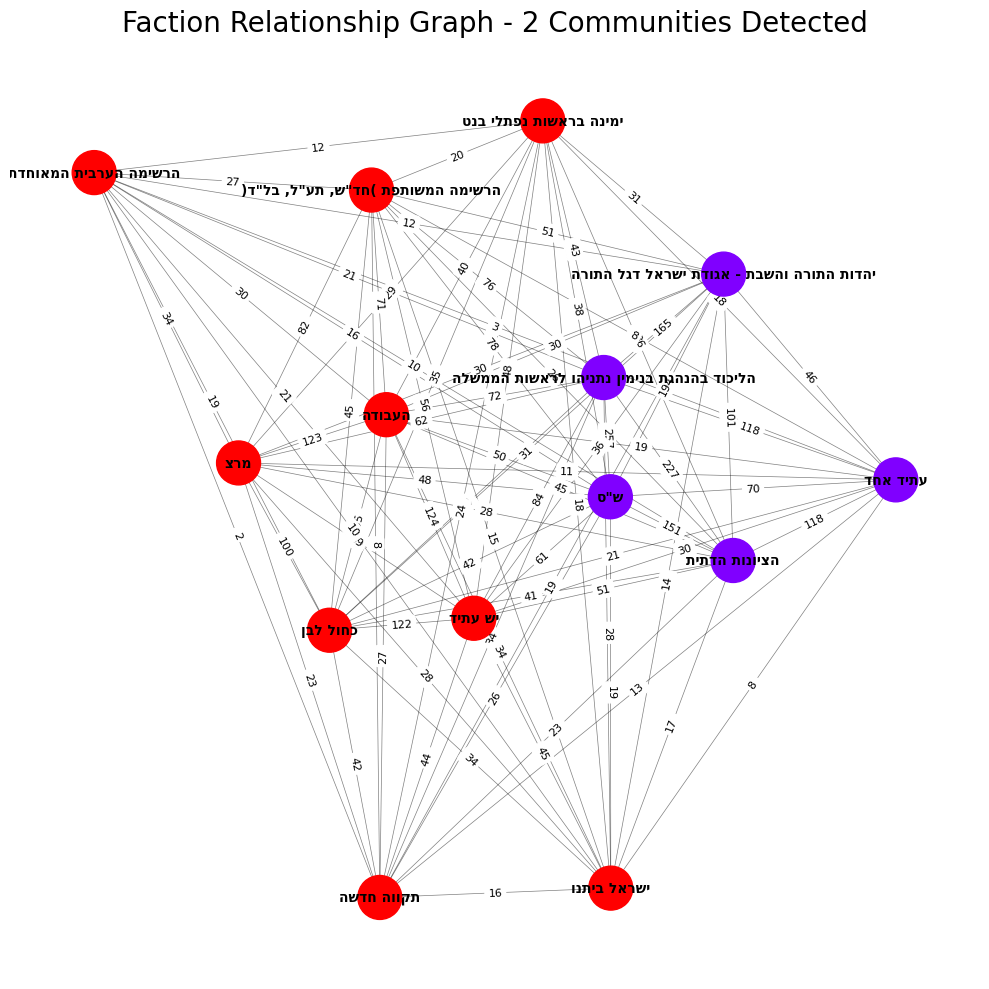

In [15]:
import numpy as np
# Draw node labels
# Generate a list of distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
color_map = {i: colors[i] for i in range(num_communities)}

# Create a larger figure
plt.figure(figsize=(10, 10))

# Draw the graph
pos = nx.spring_layout(faction_graph, k=0.5, iterations=50)


# Draw nodes colored by community
node_colors = [color_map[partition[node]] for node in faction_graph.nodes()]
nx.draw_networkx_nodes(faction_graph, pos, node_size=1000, node_color=node_colors)

# Generate a list of distinct colors
colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
color_map = {i: colors[i] for i in range(num_communities)}

nx.draw_networkx_labels(faction_graph, pos, labels=faction_names,
                        font_size=10, font_weight="bold")

# Draw edges
nx.draw_networkx_edges(faction_graph, pos, width=0.5, alpha=0.5)

# Draw edge labels (weights)
edge_weights = nx.get_edge_attributes(faction_graph, 'weight')
nx.draw_networkx_edge_labels(faction_graph, pos, edge_labels=edge_weights, font_size=8)

plt.title(f"Faction Relationship Graph - {num_communities} Communities Detected", fontsize=20)
plt.axis('off')
plt.tight_layout()

# Save the graph as a high-resolution image
plt.savefig("faction_graph_communities.png", format="png", dpi=300, bbox_inches='tight')

# Display the graph
plt.show()


# Members's Graph
We now build the lower level colaboration graph  
Each node represent a member and an edge indicated those two members colaborating together on a bill.  



In [16]:
data_for_24th_keneset = knesset_data_set(24)
data_for_24th_keneset.info()

163991lines [00:00, 164791.92lines/s]
56328lines [00:01, 51238.81lines/s]
4035lines [00:00, 17534.77lines/s]
543lines [00:00, 2395.13lines/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12895 entries, 0 to 12894
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   BillInitiatorID  12895 non-null  int64 
 1   BillID           12895 non-null  int64 
 2   PersonID         12895 non-null  int64 
 3   FactionID        12895 non-null  int64 
 4   Name             12895 non-null  object
dtypes: int64(4), object(1)
memory usage: 503.8+ KB


In [17]:
members_into = remote_loader(PERSONS_URL)
members_into.info()

1162lines [00:00, 1232.69lines/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PersonID         1162 non-null   int64 
 1   LastName         1162 non-null   object
 2   FirstName        1162 non-null   object
 3   GenderID         1162 non-null   int64 
 4   GenderDesc       1162 non-null   object
 5   Email            140 non-null    object
 6   IsCurrent        1162 non-null   bool  
 7   LastUpdatedDate  1162 non-null   object
dtypes: bool(1), int64(2), object(5)
memory usage: 64.8+ KB


In [18]:
%matplotlib inline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from community import community_louvain

def create_members_graph(df_bills, df_members):
  # Merge personal info into bills dataset to get full names
  df = df_bills.merge(df_members[['PersonID', 'FirstName', 'LastName']], on='PersonID', how='left')
  df['FullName'] = df['FirstName'].fillna('') + ' ' + df['LastName'].fillna('')
  # Since the names are in hebrew, we want to reverse them so they apear
  # correctly in the rendered graph
  df['FullName'] = df['FullName'].apply(lambda x: x[::-1])
  members_names_df = df[['PersonID','FullName']]
  person_id_to_full_name = members_names_df.set_index('PersonID')['FullName'].to_dict()
  # Group by BillID to find co-initiators
  bill_groups = df.groupby('BillID')['PersonID'].apply(list)

  # Create graph
  G = nx.Graph()

  # Add edges for co-initiators
  for names in bill_groups:
      # Add nodes and edges between all combinations of co-initiators
      for name1, name2 in combinations(set(names), 2):
          if G.has_edge(name1, name2):
              G[name1][name2]['weight'] += 1
          else:
              G.add_edge(name1, name2, weight=1)


  # Draw graph (simple layout)
  plt.figure(figsize=(25, 25))
  pos = nx.spring_layout(G, k=1.5, iterations=100)

  nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
  nx.draw_networkx_edges(G, pos, width=1, alpha=0.3)

  # Hebrew names
  nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

  # Edge labels: number of joint bills
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='gray')

  # Draw nodes and edges
  nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue')
  nx.draw_networkx_edges(G, pos, alpha=0.3)
  nx.draw_networkx_labels(G, pos, font_size=8)

  title = "חברי כנסת שיזמו חוקים יחד"
  title = title[::-1]
  plt.title(title, fontsize=20)
  plt.axis('off')
  plt.show()
  return G, person_id_to_full_name


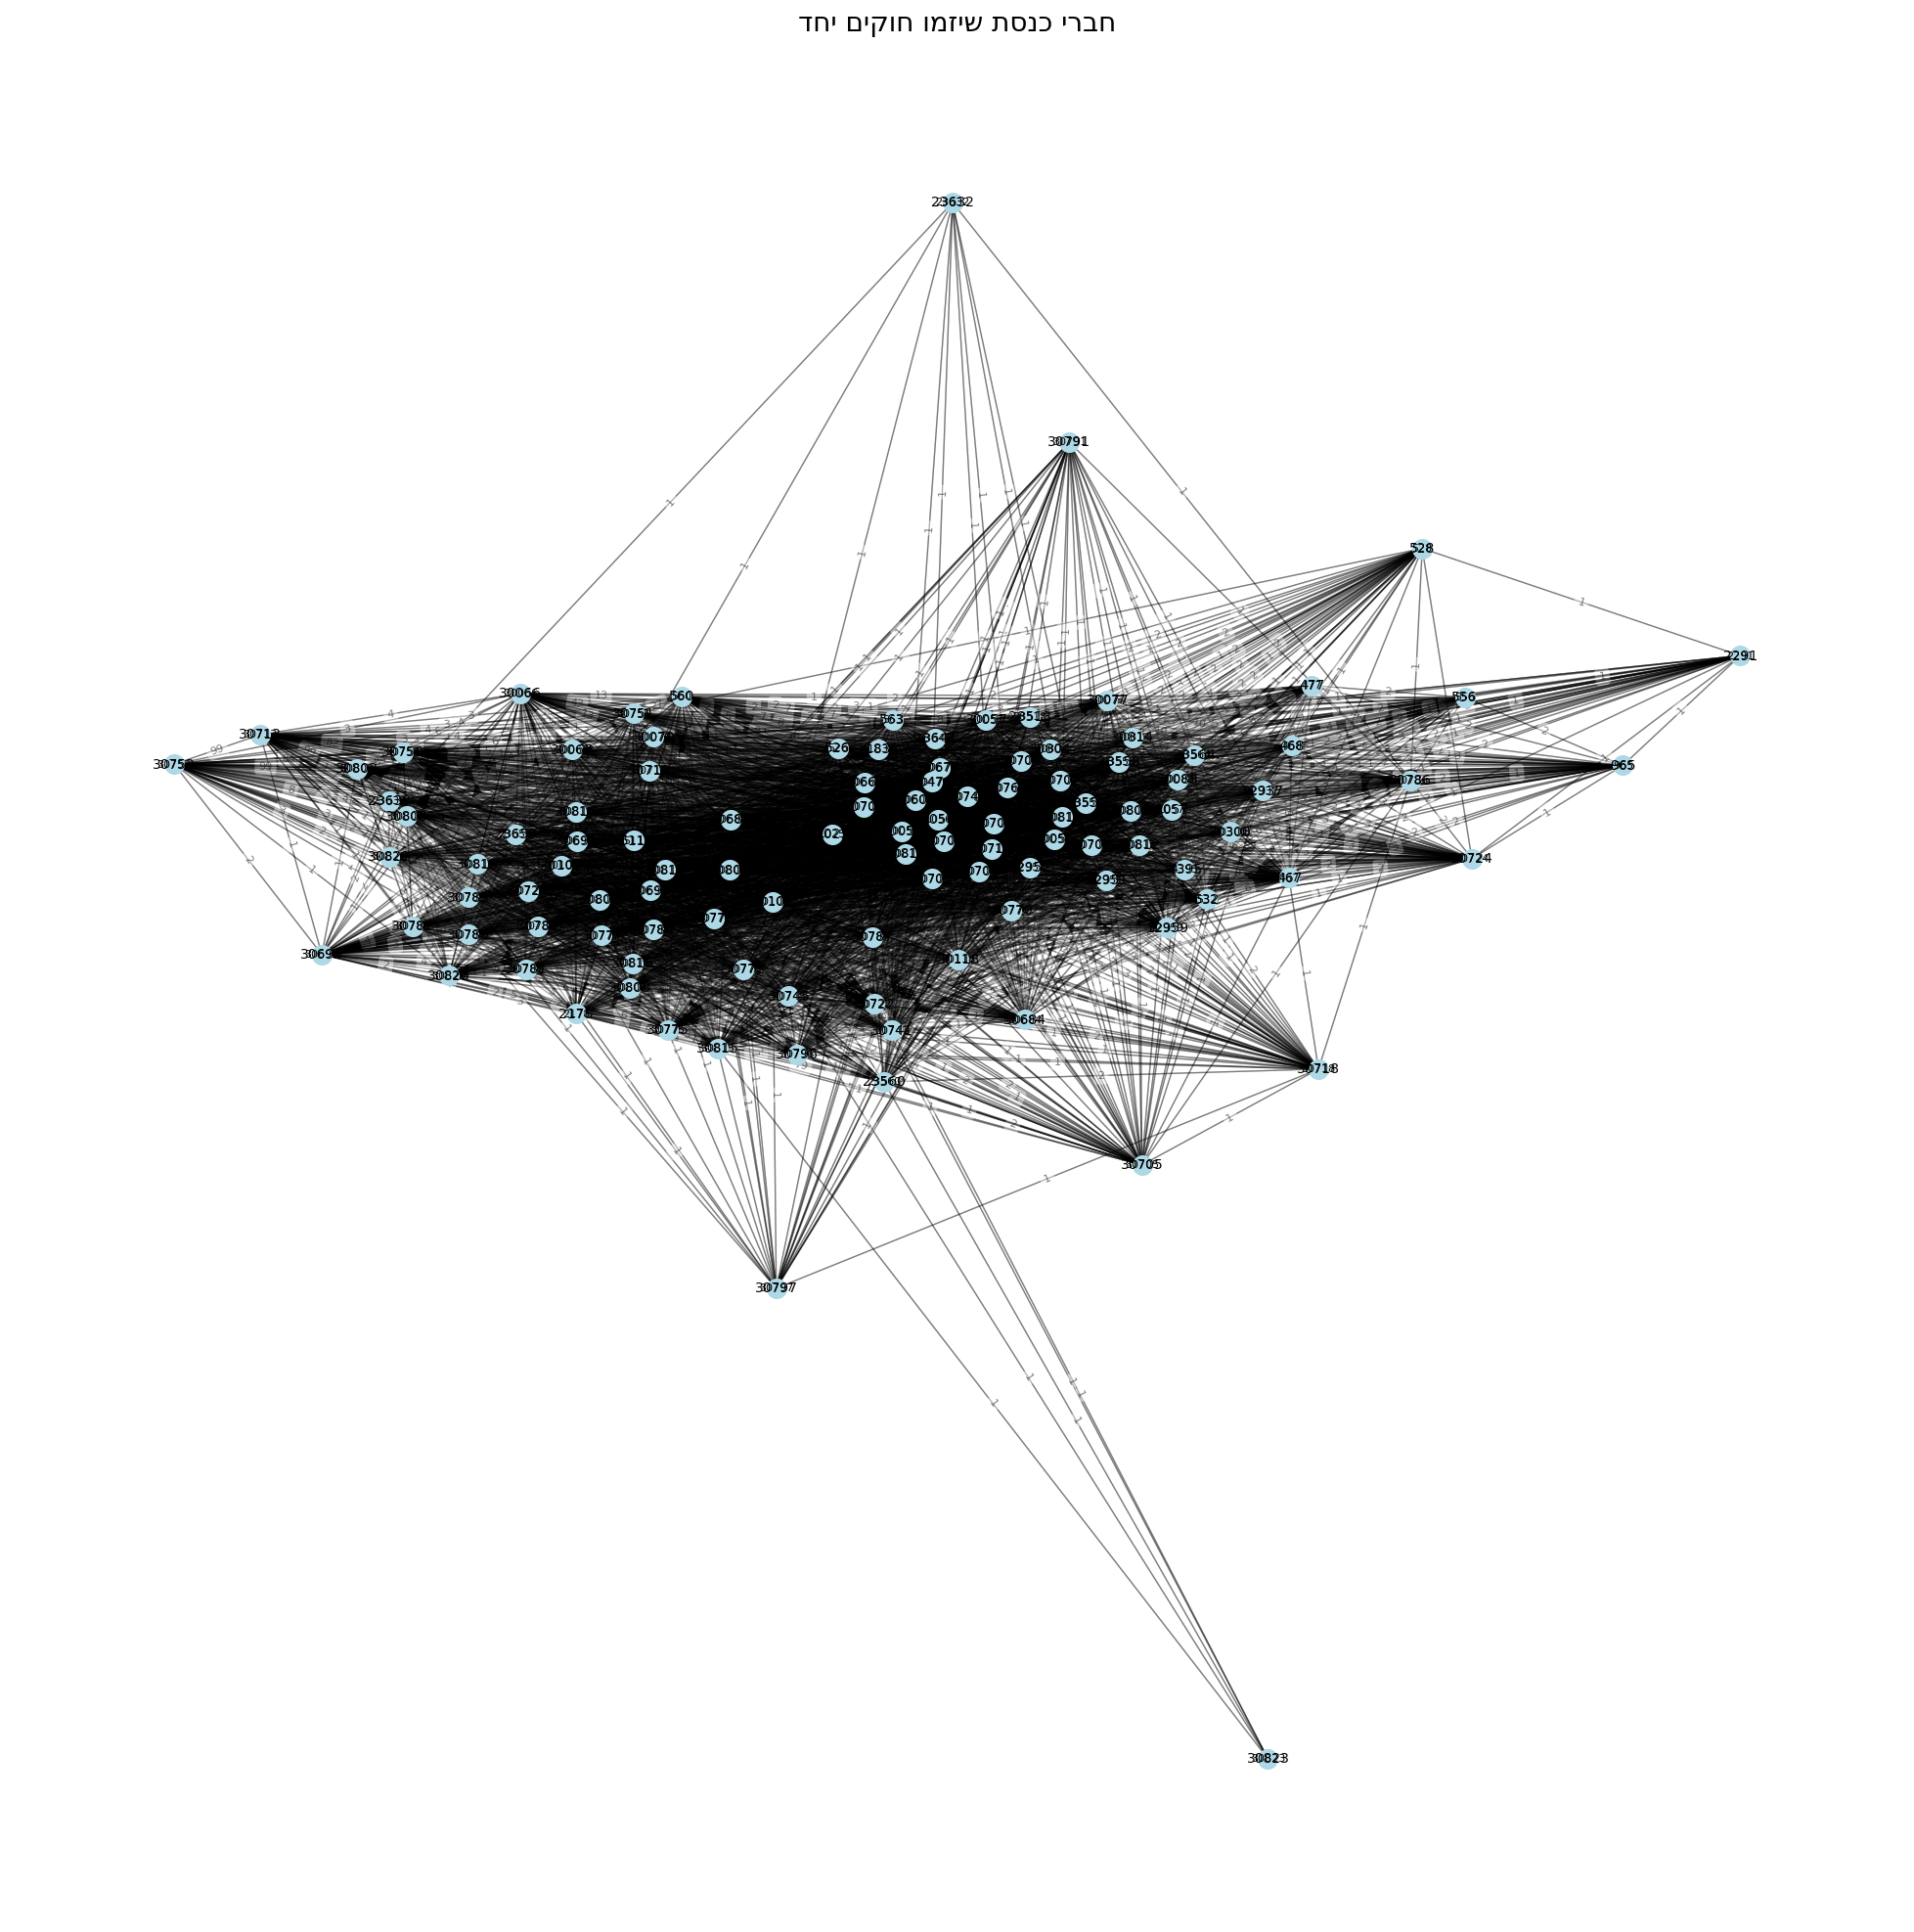

In [19]:
G, person_id_to_full_name = create_members_graph(data_for_24th_keneset,members_into)

In [20]:
# bills_and_factions =  bills_and_factions[['BillInitiatorID', 'BillID',
#                                             'PersonID', 'FactionID', 'Name']]
person_to_faction = bills_and_factions.set_index('PersonID')['FactionID'].to_dict()
print(faction_partition)
print(person_to_faction)
# def person_to_shape()


faction_partition[person_to_faction[30701]]


{np.int64(962): 0, np.int64(967): 1, np.int64(965): 0, np.int64(971): 0, np.int64(961): 0, np.int64(974): 0, np.int64(969): 1, np.int64(970): 1, np.int64(963): 1, np.int64(966): 1, np.int64(968): 1, np.int64(972): 1, np.int64(964): 1, np.int64(973): 1}
{30701: 962, 30067: 964, 30719: 964, 30066: 964, 30672: 965, 23641: 965, 526: 965, 30749: 971, 30470: 971, 30702: 962, 30601: 971, 30660: 971, 30717: 974, 30812: 961, 30810: 961, 23551: 961, 30055: 961, 30704: 962, 30058: 962, 30741: 968, 23560: 968, 30722: 968, 1057: 965, 23632: 967, 30721: 967, 30118: 972, 23651: 970, 30070: 964, 560: 964, 30693: 969, 30706: 962, 1056: 971, 30787: 966, 30703: 962, 30776: 967, 30775: 969, 30813: 963, 30696: 963, 30808: 963, 30807: 963, 30806: 963, 23639: 967, 23591: 967, 30708: 962, 30811: 961, 30765: 971, 4395: 962, 30805: 970, 511: 970, 30102: 967, 30804: 971, 23565: 963, 30680: 972, 30686: 967, 30743: 970, 23631: 967, 30780: 967, 30720: 967, 30814: 961, 30786: 966, 30691: 967, 30718: 966, 30700: 962,

0

In [21]:
import matplotlib.patches as mpatches
def create_person_to_shape_map(person_to_faction, faction_partition):
  def shape_person(person_id, plt, pos, node, color):
    partition_number = faction_partition[person_to_faction[person_id]]
    if partition_number == 1:
      # Draw larger square for community 1
      rect = mpatches.Rectangle((pos[node][0]-0.025, pos[node][1]-0.025),
                                width=0.02, height=0.02,
                                facecolor=color, edgecolor='none')
      plt.gca().add_patch(rect)
    else:
      # Draw larger circle for community 0
            circle = mpatches.Circle((pos[node][0], pos[node][1]), radius=0.01,
                                    facecolor=color, edgecolor='none')
            plt.gca().add_patch(circle)


  return shape_person



In [22]:
shape_person = create_person_to_shape_map(person_to_faction, faction_partition)

In [54]:
import plotly.graph_objects as go

def draw_combines_graph(G, person_id_to_full_name):
  # Perform community detection
  members_partition = community_louvain.best_partition(G)
  # Get the number of communities
  num_communities = len(set(members_partition.values()))
  # Generate a list of distinct colors
  colors = plt.cm.rainbow(np.linspace(0, 1, num_communities))
  color_map = {i: colors[i] for i in range(num_communities)}

  # Create a larger figure
  plt.figure(figsize=(25, 25))

  # Draw the graph
  pos = nx.spring_layout(G, k=0.5, iterations=50)
  # Draw edges
  edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
  nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3, edge_color=edge_weights)
  # Draw nodes colored by community and shaped by faction community type
  for node in G.nodes():
      color = color_map[members_partition[node]]
      faction_id = person_to_faction.get(node)
      # shape the node according to faction partition
      shape_person(node, plt, pos, node, color)
      # Add labels (PersonIDs) to the nodes
      labels = {node: str(node) for node in G.nodes()}
      nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold')

  # Add name annotations as static "hover" replacements
  for node_id, (x, y) in pos.items():
    name = person_id_to_full_name[node_id]
    plt.text(x, y + 0.03, name, fontsize=8, ha='center', color='gray')

  # Save the graph as a high-resolution image
  plt.savefig("person_graph_communities_with_labels.png", format="png", dpi=300, bbox_inches='tight')

  # Display the graph
  plt.show()
  return pos


print(partition)
print(person_id_to_full_name)


{np.int64(962): 0, np.int64(967): 1, np.int64(965): 0, np.int64(971): 0, np.int64(961): 0, np.int64(974): 0, np.int64(969): 1, np.int64(970): 1, np.int64(963): 1, np.int64(966): 1, np.int64(968): 1, np.int64(972): 1, np.int64(964): 1, np.int64(973): 1}
{30701: 'ץכ ריפוא', 30067: 'ןאמילס אמות הדיאע', 30719: 'ףיסכ רפוע', 30066: 'הדוע ןמייא', 30672: 'סורדניפ קחצי', 23641: 'רשא בקעי', 526: 'ינפג השמ', 30749: 'לובטובא השמ', 30470: 'ילאיכלמ לאכימ', 30702: 'הייטע יתא הוח', 30601: 'יאלוזא ןוני', 30660: 'לברא השמ', 30717: 'רפוס ריפוא', 30812: 'ןמטור החמש', 30810: 'רגידלוו םירמ לכימ', 23551: 'קורטס הכלמ תירוא', 30055: "'ץירטומס לאלצב", 30704: 'יערק המלש', 30058: 'רהוז יקימ ףולכמ', 30741: 'רינשוק סכלא', 23560: 'יקסבונילמ הילוי', 30722: 'הבוס ינגבי', 1057: 'רלכייא לארשי', 23632: 'יול יקימ', 30721: 'לור ןדיע', 30118: 'לכשה םירמ ןרש', 23651: 'גרבדנז רמת', 30070: 'ידעס המאסוא', 560: 'יביט דמחא', 30693: 'גרובזניג ןתיא', 30706: 'תירטש ןירטק יטק', 1056: 'יגרמ בקעי', 30787: 'ךברוא רינ', 30703: 'קרב ןרק',

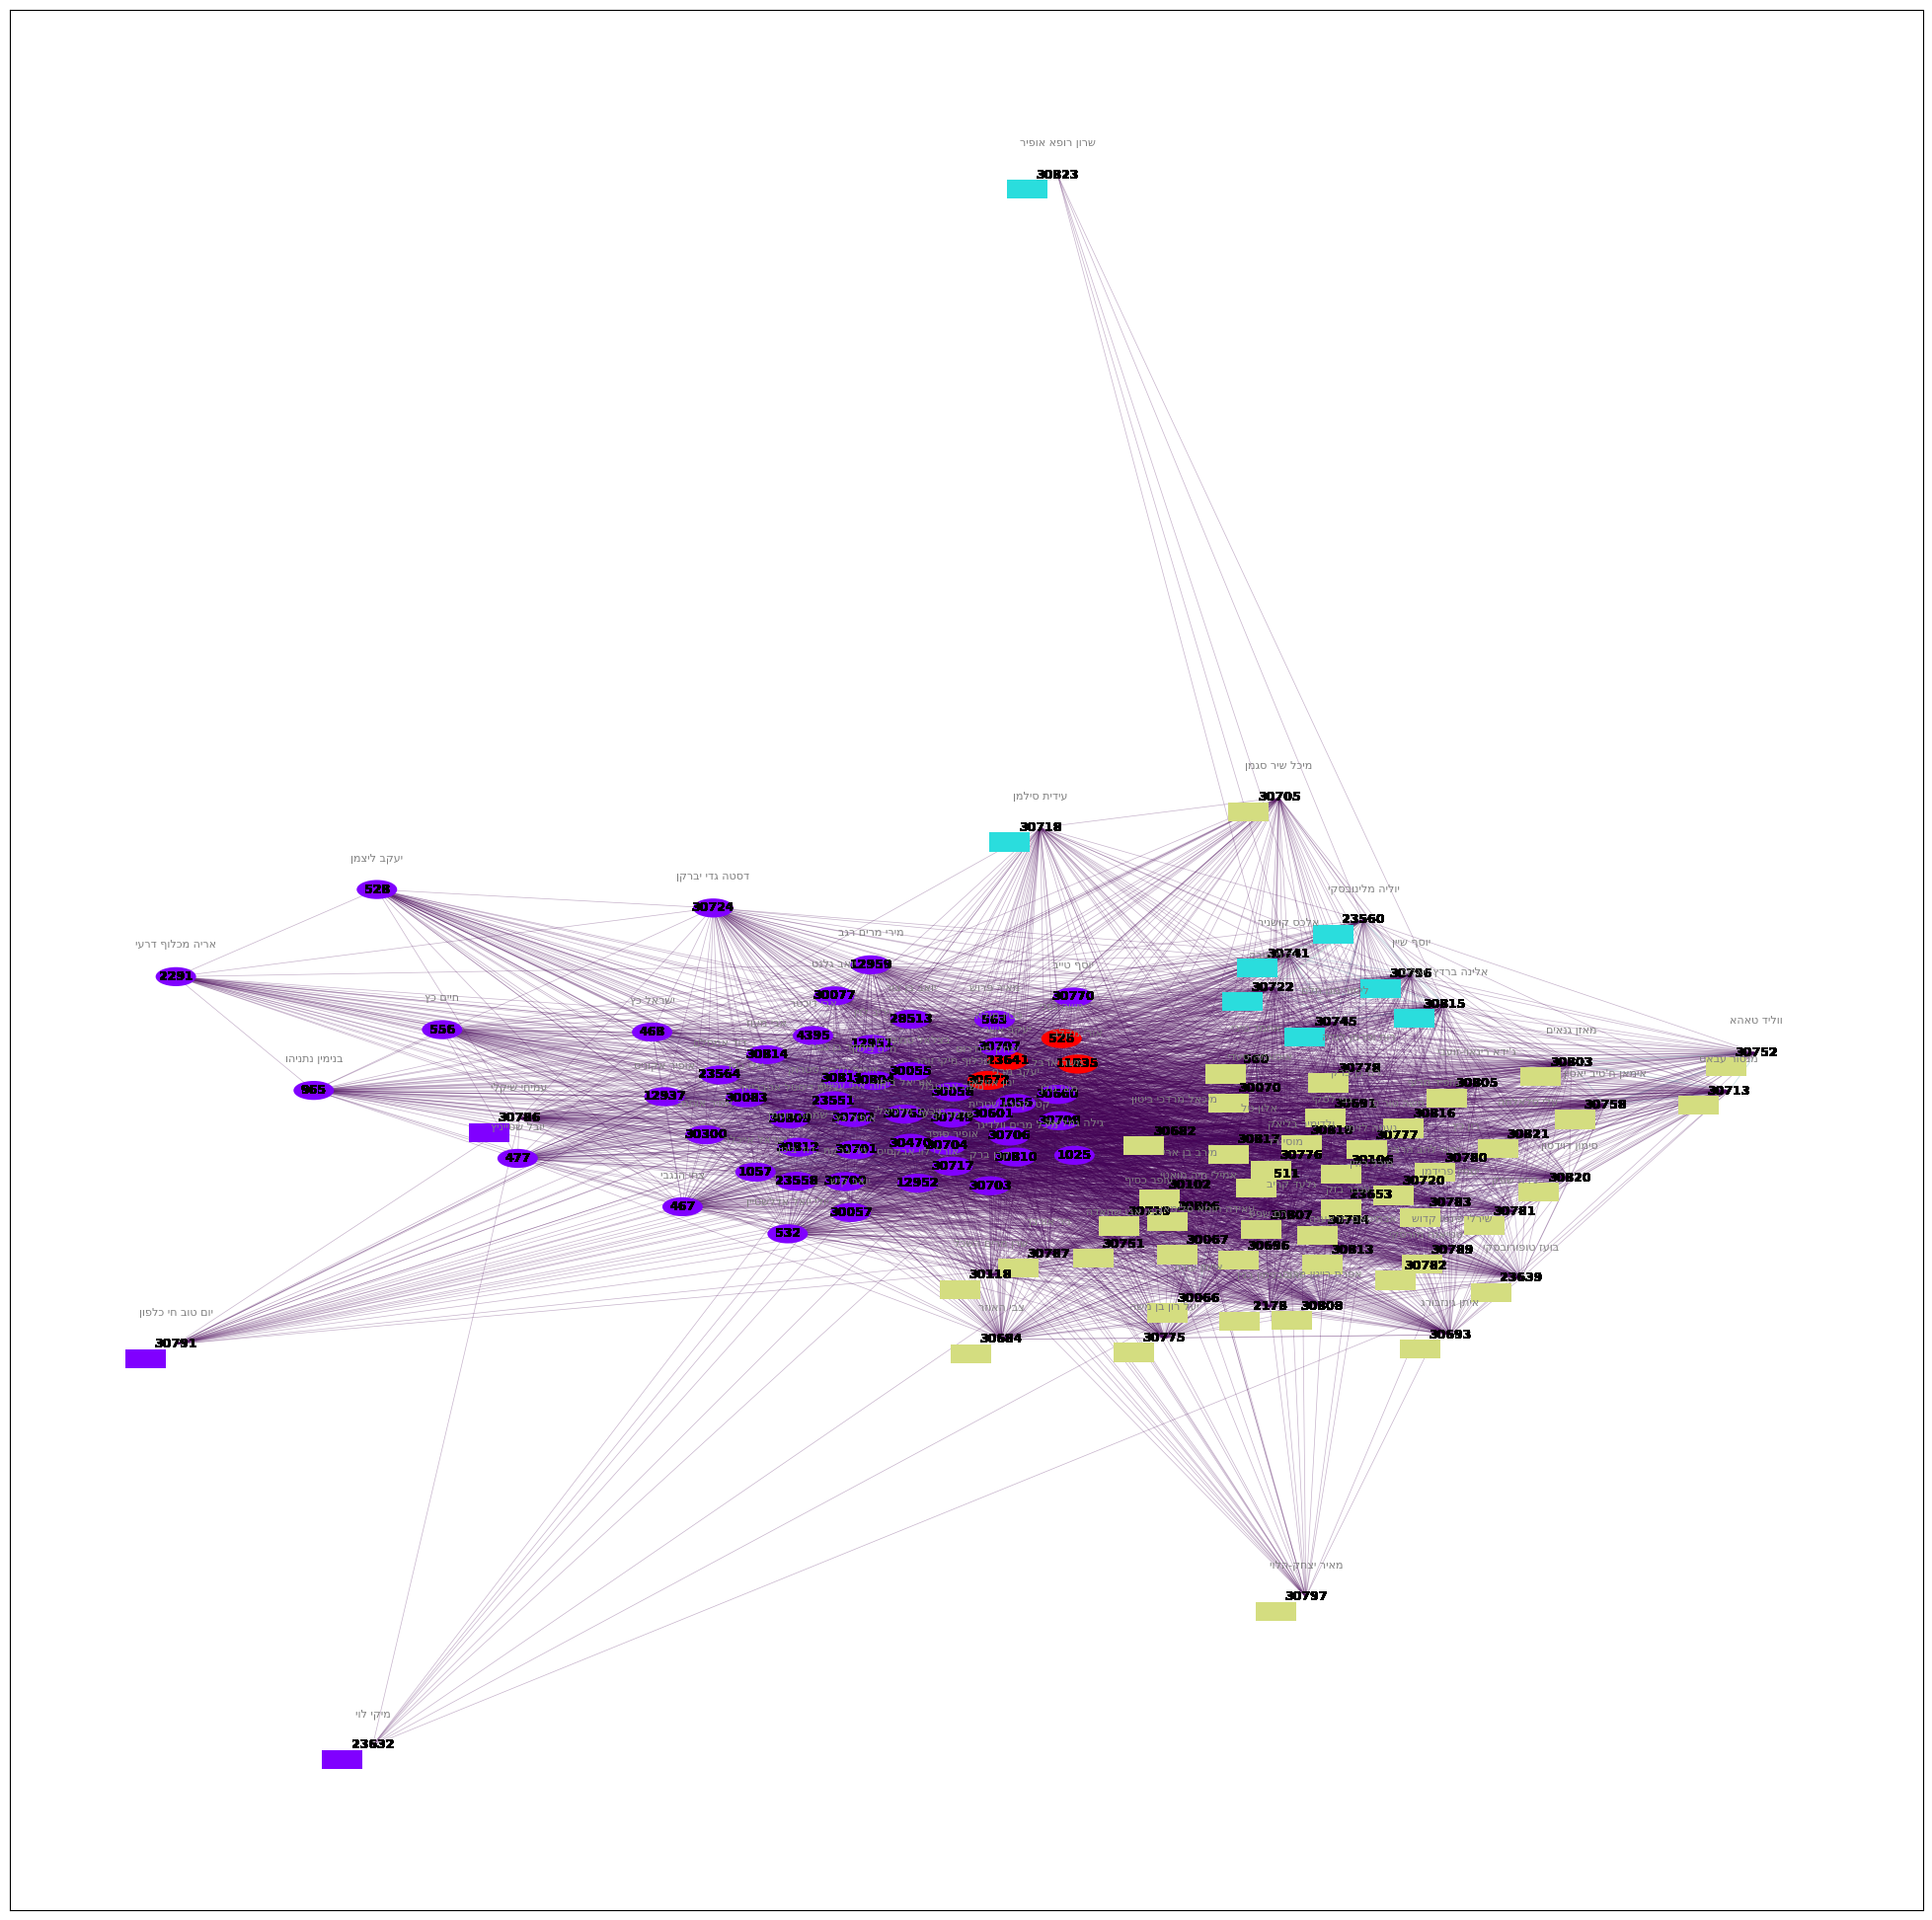

In [55]:
position = draw_combines_graph(G, person_id_to_full_name)

In [53]:
for node_id, (x, y) in position.items():
  node_id = int(node_id)
  name = person_id_to_full_name[node_id]  # FIXED LINE
  print(node_id)
  print(name)

  #   name = person_id_to_full_name[G.nodes[node_id]]
  #   plt.text(x, y + 0.03, name, fontsize=8, ha='center', color='gray')

30701
ץכ ריפוא
30102
ירא ןב ברימ
30066
הדוע ןמייא
30067
ןאמילס אמות הדיאע
30719
ףיסכ רפוע
30672
סורדניפ קחצי
23641
רשא בקעי
30601
יאלוזא ןוני
526
ינפג השמ
1056
יגרמ בקעי
1057
רלכייא לארשי
30765
וסוב לאירוא
30704
יערק המלש
30706
תירטש ןירטק יטק
30708
ןלוג יאמ
30804
ןוטיב םייח
30749
לובטובא השמ
30660
לברא השמ
30055
'ץירטומס לאלצב
30810
רגידלוו םירמ לכימ
30812
ןמטור החמש
30717
רפוס ריפוא
23551
קורטס הכלמ תירוא
23560
יקסבונילמ הילוי
30722
הבוס ינגבי
30741
רינשוק סכלא
30817
לט ןולא
30818
יקסל יבג
30821
החלאלס ילע
23653
ןיזור לכימ
30813
הנעארמ םאסיתבא
511
זר יסומ
30470
ילאיכלמ לאכימ
30118
לכשה םירמ ןרש
4395
רטכיד יבא
556
ץכ םייח
30787
ךברוא רינ
30811
ריבג ןב רמתיא
30809
ןאירבטא לטסיד תילג
30814
זועמ יבא
30058
רהוז יקימ ףולכמ
30700
תקרב רינ
30702
הייטע יתא הוח
30703
קרב ןרק
30070
ידעס המאסוא
560
יביט דמחא
30805
יבעוז-יואניר אדי'ג
30693
גרובזניג ןתיא
30776
קאילב רימידלו
30808
םורמ ןטייר תרפא
30718
ןמליס תידיע
30696
עפש םר
30806
יטאומ היח ילימא
30807
בירק דעלג
30781
קפש הרינ
30775
השמ ןב ןור לע

In [36]:
person_id_to_full_name[970]

KeyError: 970